# 2A.algo - Hash et distribution

Une [fonction de hash](https://en.wikipedia.org/wiki/Hash_function) a pour propriété statistiques de transformer une distribution quelconque en distribution uniforme. C'est pour cela que beaucoup d'algorithmes utilisent ce type de fonction avant tout traitement pour répartir les données de manières uniformes plutôt que d'utiliser une variable une colonne telle quelle.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupérer un fichier wikipédia

In [ ]:
from mlstatpy.data.wikipedia import download_pageviews
import os
from datetime import datetime

download_pageviews(datetime(2016,11,1), folder=".")

'.\\pageviews-20161101-000000'

On ne garde que les pages françaises.

In [ ]:
with open("pageviews-20161101-000000", "r", encoding="utf-8") as f:
    fr = filter(lambda line: line.startswith("fr "), f)
    with open("pageviews-20161101-000000.fr.txt", "w", encoding="utf-8") as g:
        for line in fr:
            g.write(line)

In [ ]:
import pandas
df = pandas.read_csv("pageviews-20161101-000000.fr.txt", encoding="utf-8", sep=" ", header=None)
df.columns="country page impressions _".split()
df = df[["page", "impressions"]]
df = df.sort_values("impressions", ascending=False)
print(df.shape)
df.head()

(160246, 3)


,page,impressions,country
153989,Wikipédia:Accueil_principal,9360,fr
137046,Spécial:Recherche,3359,fr
337,-,2369,fr
54231,France,1021,fr
62384,Halloween,685,fr


Les données sont biaisées car les pages non démandées par les utilisateurs sur cett date ne sont pas répertoriées mais cela ne nuit pas à la démonstration faite ci-dessous.

## Distribution volume, impressions par rapprt au premier caractère

In [ ]:
df["ch1"] = df["page"].apply(lambda r: r[0] if isinstance(r, str) else r)
df.head()

,page,impressions,country,ch1
153989,Wikipédia:Accueil_principal,9360,fr,W
137046,Spécial:Recherche,3359,fr,S
337,-,2369,fr,-
54231,France,1021,fr,F
62384,Halloween,685,fr,H


In [ ]:
co = df.copy()
co["volume"] = 1
gr = co.groupby("ch1", as_index=False).sum().sort_values("ch1")
gr.head()

,ch1,impressions,volume
0,,5,1
1,!,14,12
2,$,25,22
3,%,18,18
4,&,19,9


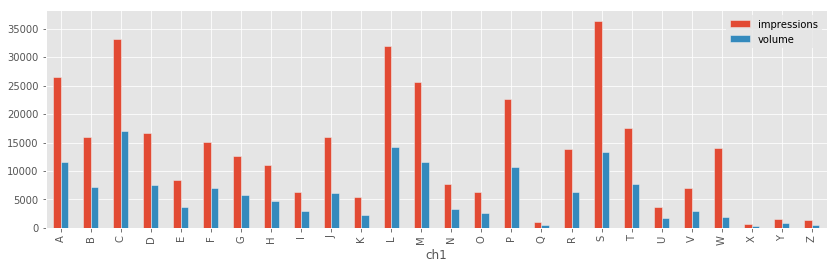

In [ ]:
gr[(gr["ch1"] >= "A") & (gr["ch1"] <= "Z")].plot(x="ch1", y=["impressions", "volume"], kind="bar", figsize=(14,4))

Il est possible de distribuer les impressions et les volumns sur plusieurs machines mais ce serait beaucoup plus simple si les volumes (volume de données) et les impressions (usage de ces données) suivent des distributions identiques.

## Distribution après hashage

In [ ]:
import hashlib
def hash(text):
    md5 = hashlib.md5()
    md5.update(text.encode('utf-8'))
    return md5.hexdigest()

hash("France")

'0309a6c666a7a803fdb9db95de71cf01'

In [ ]:
ha = co.copy()
ha["hash"] = ha["page"].apply(lambda r: hash(r) if isinstance(r, str) else r)
ha.head()

,page,impressions,country,ch1,volume,hash
153989,Wikipédia:Accueil_principal,9360,fr,W,1,6cc68aa5234cb8c4e129d5b431eea95a
137046,Spécial:Recherche,3359,fr,S,1,6f86a30966129c5bf50147eb44c4e82c
337,-,2369,fr,-,1,336d5ebc5436534e61d16e63ddfca327
54231,France,1021,fr,F,1,0309a6c666a7a803fdb9db95de71cf01
62384,Halloween,685,fr,H,1,e1114432a2ac994a333544d5da17e1fb


In [ ]:
ha["ch2"] = ha["hash"].apply(lambda r: r[0] if isinstance(r, str) else r)
ha.head()

,page,impressions,country,ch1,volume,hash,ch2
153989,Wikipédia:Accueil_principal,9360,fr,W,1,6cc68aa5234cb8c4e129d5b431eea95a,6
137046,Spécial:Recherche,3359,fr,S,1,6f86a30966129c5bf50147eb44c4e82c,6
337,-,2369,fr,-,1,336d5ebc5436534e61d16e63ddfca327,3
54231,France,1021,fr,F,1,0309a6c666a7a803fdb9db95de71cf01,0
62384,Halloween,685,fr,H,1,e1114432a2ac994a333544d5da17e1fb,e


In [ ]:
gr = ha.groupby("ch2", as_index=False).sum().sort_values("ch2")
gr.head()

,ch2,impressions,volume
0,0,23789,9945
1,1,22091,10002
2,2,22336,9937
3,3,23573,10012
4,4,21895,10057


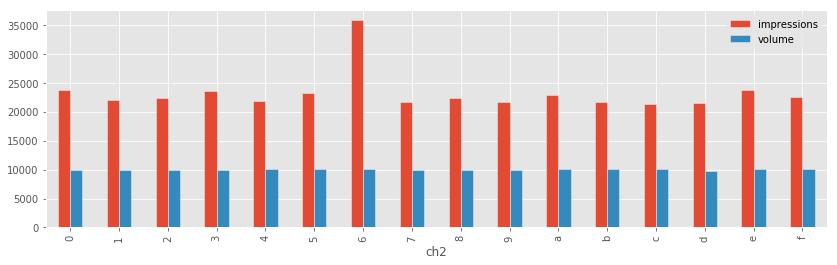

In [ ]:
gr.plot(x="ch2", y=["impressions", "volume"], kind="bar", figsize=(14,4))

Après avoir appliqué une fonction de hashage, les deux distributions volumes et impressions sont presque uniforme par rapport au premier caractère du hash. Il reste un pic : il provient de la page wikipédia la plus demandée. Ces pages très demandées sont très souvent en très petit nombre et on implémentera une mécanisme de cache s'il s'agit d'un site web. En revanche, lors d'un calcul distribué sur Map / Reduce, un des problèmes consistera à traiter ces clés de distributions qui regroupent une part trop importante des données.

On recommence le même raisonnement en utilisant les deux premiers caractères du hash comme clé de distribution.

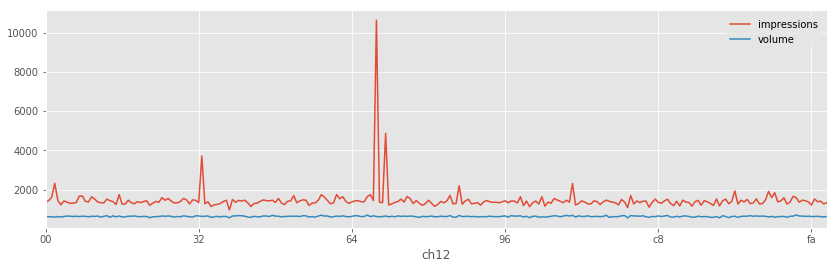

In [ ]:
def substr(s, size=2):
    if isinstance(s, str):
        if len(s) < size: 
            return s
        else:
            return s[:size]
    else:
        return s
    
ha["ch12"] = ha["hash"].apply(lambda r: substr(r))
gr = ha.groupby("ch12", as_index=False).sum().sort_values("ch12")
gr.plot(x="ch12", y=["impressions", "volume"], figsize=(14,4))

Dans ce cas précis, si le traitement appliqué aux données est d'un coût proportionnelle à la taille des données associées à chaque clé, cela signifie qu'une opération de type **reduce** aura un temps de traitement proportionnel au volume de données associée à la plus grande clé et non au nombre de machines puisque toutes les données d'une même clé sont envoyées sur la même machine.